In [1]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import itertools

# Get Data 
---

In [2]:
prices = pd.read_csv("binance_data/From_Paper/2023/1m/merged_From_Paper_closing_prices_OCT_NOV.csv", index_col=0, parse_dates=True)

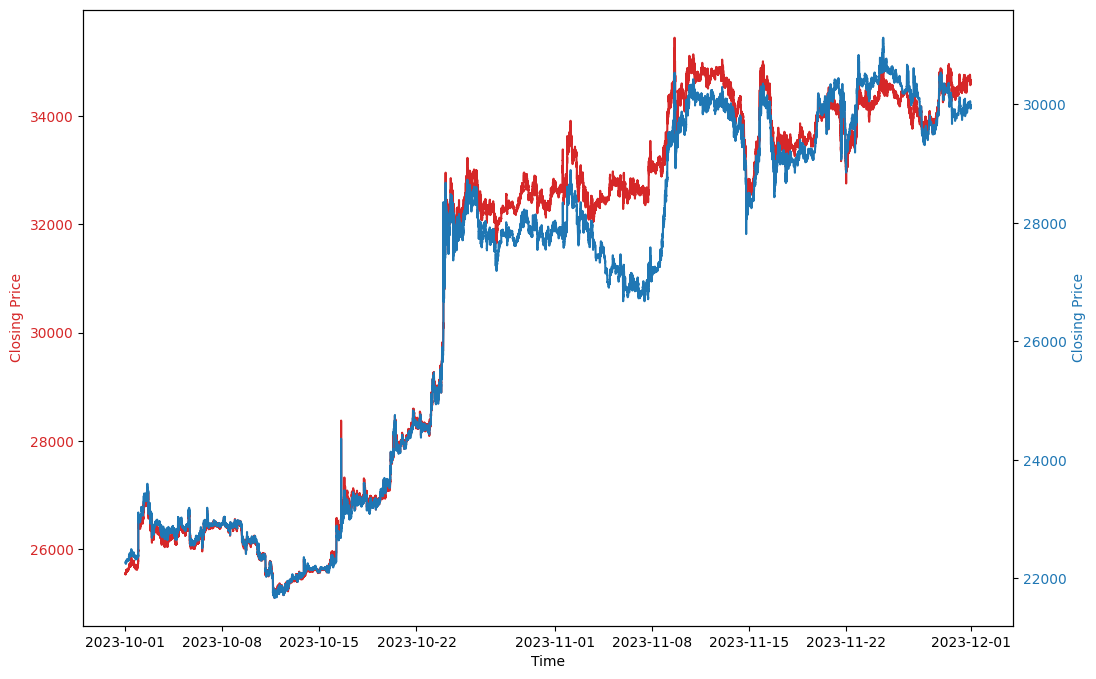

In [3]:
#Plot the closing prices of the merged data using different y axis


fig, ax1 = plt.subplots()

#Set size of the plot
fig.set_size_inches(12, 8)

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Closing Price', color=color)
ax1.plot(prices.index, prices['BTCEUR_2023_1m'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Closing Price', color=color)
ax2.plot(prices.index, prices['BTCGBP_2023_1m'], color=color)
ax2.tick_params(axis='y', labelcolor=color)





In [4]:
#Calculate correlation matrix
correlation_matrix = prices.corr()
correlation_matrix

,BTCEUR_2023_1m,BTCGBP_2023_1m
BTCEUR_2023_1m,1.000000,0.989894
BTCGBP_2023_1m,0.989894,1.000000


# Applly funnel and test for cointegration
---

In [5]:

# # Pre-filter: Calculate correlation matrix and select pairs with high correlation
# corr_threshold = 0.8
# corr_matrix, high_corr_pairs = filter_high_correlation_pairs(prices, threshold=corr_threshold)
# print(f"\nPairs with correlation >= {corr_threshold}:")
# for pair in high_corr_pairs:
#     print(f"{pair[0]} & {pair[1]}: correlation = {pair[2]:.4f}")

# # Cointegration test
# cointegrated_pairs, pvalue_matrix, residuals_df = find_cointegrated_pairs(prices, high_corr_pairs,significance=0.05)
# #cointegrated_pairs, window_results = find_cointegrated_pairs_windows(prices, high_corr_pairs, significance=0.05, window_size=720, min_pass_fraction=0.5)


In [6]:
# cointegrated_pairs = [('BNB/USDT_2024_1h',
#   'BTC/USDT_2024_1h',
#   0.731393,
#   0.8501886494196308)]

In [7]:
# #If you suspect daily intraday patterns, using 24 lags is a natural choice: it checks each hour in a 24-hour cycle for dependence.
# #If your sample is large enough (covering many days/weeks), 24 lags is typically enough to detect standard intraday correlation
# analyze_residuals(residuals_df, lags = 24)

In [8]:
# cointegrated_pairs

# Test cointegration function on data designed to be cointegrated
---

In [9]:
# import numpy as np
# import pandas as pd

# def generate_cointegrated_data(
#     n=720,  # number of data points
#     alpha=5.0,
#     beta=1.5,
#     phi=0.8,
#     seed=42
# ):
#     """
#     Generate two cointegrated series: S1 (random walk) and S2 (linear function of S1 + stationary AR(1) noise).
    
#     Parameters:
#         n (int): Number of observations (e.g. 720 for ~1 month of hourly data).
#         alpha (float): Intercept term for S2.
#         beta (float): S2 coefficient for S1.
#         phi (float): AR(1) coefficient for the noise in S2 - beta*S1. Must be <1 in abs value for stationarity.
#         seed (int): Random seed for reproducibility.

#     Returns:
#         pd.DataFrame with columns ['S1', 'S2'] representing the two cointegrated time series.
#     """
#     rng = np.random.default_rng(seed)
    
#     # 1) Generate S1 as a random walk
#     #   S1_t = S1_{t-1} + e1_t
#     e1 = rng.normal(loc=0.0, scale=1.0, size=n)
#     S1 = np.cumsum(e1)  # cumsum => random walk
    
#     # 2) Generate a stationary AR(1) noise for the spread
#     #   ARnoise_t = phi * ARnoise_{t-1} + e2_t
#     e2 = rng.normal(loc=0.0, scale=1.0, size=n)
#     ARnoise = np.zeros(n)
#     for t in range(1, n):
#         ARnoise[t] = phi * ARnoise[t-1] + e2[t]
#     # ARnoise is stationary if |phi| < 1
    
#     # 3) Define S2 = alpha + beta*S1 + AR(1) noise
#     S2 = alpha + beta*S1 + ARnoise
    
#     # Put them in a DataFrame
#     df = pd.DataFrame({'S1': S1, 'S2': S2})
#     return df

# # Example usage
# if __name__ == "__main__":
#     df_cointegrated = generate_cointegrated_data(n=720)
#     print(df_cointegrated.head(10))


In [10]:
# # Suppose df has columns: 'S1', 'S2'
# alpha = 5.0
# beta = 1.5

# # Calculate the spread: S2 - (alpha + beta * S1)
# df_cointegrated['spread'] = df_cointegrated['S2'] - alpha - beta * df_cointegrated['S1']

# # Plot
# plt.figure(figsize=(10,6))
# plt.plot(df_cointegrated['spread'], label='Spread = S2 - alpha - beta*S1')
# plt.axhline(df_cointegrated['spread'].mean(), color='red', linestyle='--', label='Mean')
# plt.title('Spread Over Time')
# plt.legend()
# plt.show()


# Windows
---

### On data designed to be cointegrated

In [11]:
high_corr_pairs = []

In [12]:
# cointegrated_pairs, window_results = find_cointegrated_pairs_windows(df_cointegrated, high_corr_pairs, significance=0.05, window_size=240, min_pass_fraction=0.5)

In [13]:
# window_results

# Test cointegration on actual data
---

In [14]:
cointegrated_pairs, window_results = find_cointegrated_pairs_windows(prices, high_corr_pairs, significance=0.05, window_size=1440, min_pass_fraction=0.5)


Cointegrated pairs (across windows):
BTCEUR_2023_1m & BTCGBP_2023_1m: pass fraction=0.51, avg p-value=0.1793, correlation=0.0


In [15]:
# windows = split_price_series_into_windows(prices, window_size=1440)

# #For ICP/USDT_2024_1h', 'ADA/USDT_2024_1h
# plot_spread_in_windows('BTCEUR_2023_1m', 'BTCGBP_2023_1m', windows, window_results, significance=0.05) #These spreads look like they are standardised, but they are not. They are centered around 0 due to the inclusion of the intercept term in the cointegration test. The spread is still in the original units of the data.
# #plot_spread_in_windows('S1', 'S2', windows, window_results, significance=0.05)

# Trading simulation
---

* ## In-Sample Testing

In [20]:
if cointegrated_pairs:
        sym1, sym2, pass_fraction, avg_p_value,correlation = cointegrated_pairs[0]
        print(f"\nTesting strategy on pair: {sym1} and {sym2} (pass_fractioon: {pass_fraction:.4f},average_p_value: {avg_p_value:.4f} correlation: {correlation:.4f})")
        S1 = prices[sym1]
        S2 = prices[sym2]
        
        # Compute the spread series and beta_series 
        spread_series, beta_series = compute_spread_series(S1, S2, window_size=1440)
        #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

        # Compute rolling z-score using the provided helper function.
        zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size = 1440)
        
        # Generate trading signals (positions) based on the spread's z-score
        positions_series, win_indexs, loss_indexs = backtest_pair_rolling(spread_series,zscore_series, entry_threshold=1.0, exit_threshold=0.1, stop_loss_threshold=2.0)
        
        #Simulate strategy performance
        #pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)
        
        pnl, cum_pnl = simulate_true_strategy_rolling(S1, S2, positions_series, beta_series)
        


Testing strategy on pair: BTCEUR_2023_1m and BTCGBP_2023_1m (pass_fractioon: 0.5082,average_p_value: 0.1793 correlation: 0.0000)
Total trades closed: 3299 (Wins=1352, Losses=1947)
Win rate: 0.41


Long Entries In Window: 5, Short Entries In Window: 2
Wins In Window: 5, Losses In Window: 2


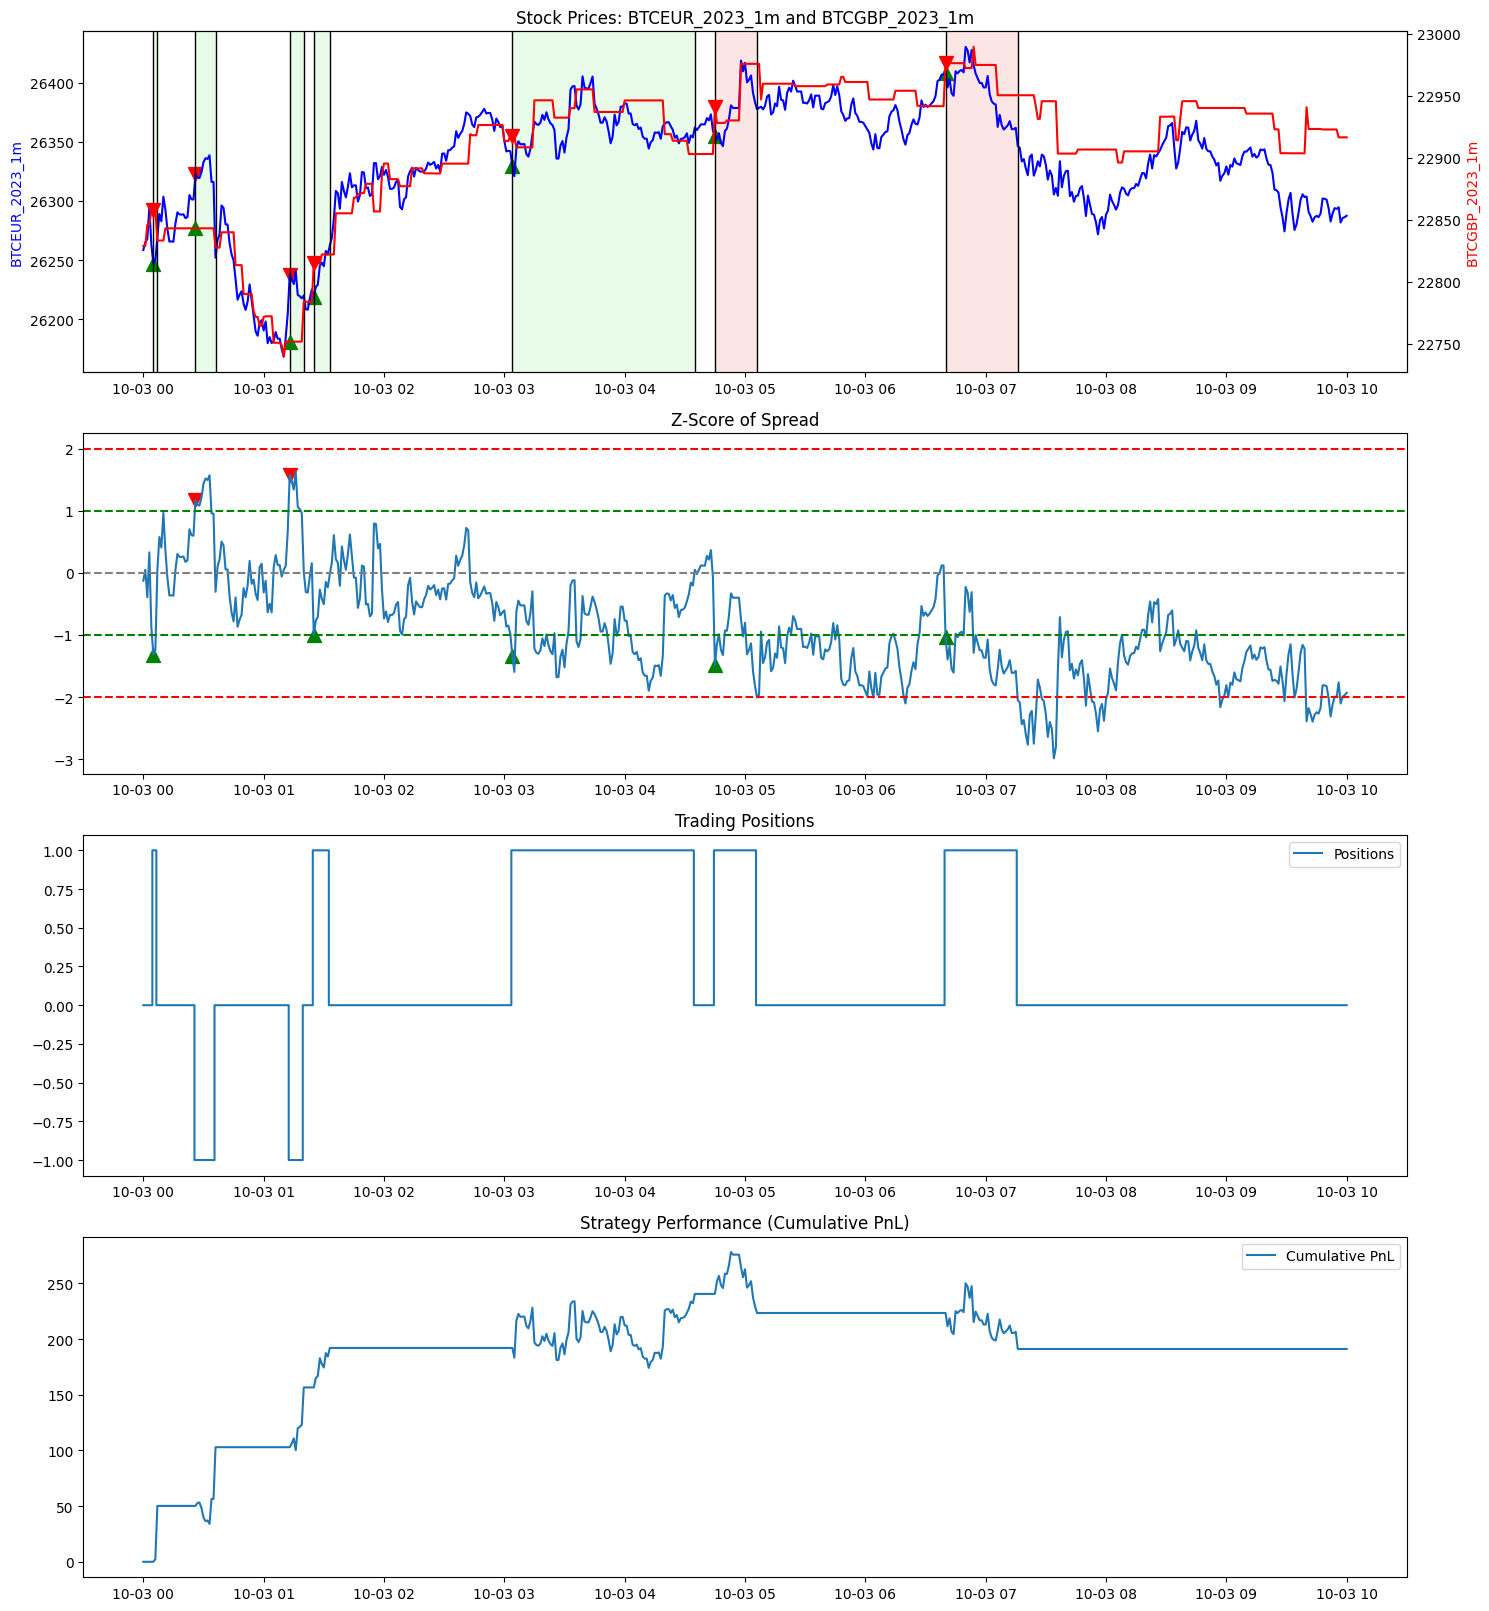

In [28]:
#Plot trading simulation
window_start = '2023-10-03 00:00:00'
window_end = '2023-10-03 10:00:00' 
plot_trading_simulation(S1, S2, sym1,sym2,zscore_series, positions_series, 
                        cum_pnl,win_indexs=win_indexs,loss_indexs=loss_indexs,
                        window_start=window_start, window_end=window_end)